<h1><center> EL7006 - Tarea Nº4 <br /> Generative Models: Generative Adversarial Networks <br/> </center></h1>
<h3><center>Profesor: Pablo Estévez <br />
Profesor Auxiliar: Jhon Intriago <br />
Ayudantes: Bastián Gamboa, Daniel Neira, Giovanni Castiglioni <br />
<h3><center>Semestre: Primavera 2022 </center></h3>

<h1><center><u>Parte Teórica</u></center></h1>

Responda las siguientes preguntas respecto a GANs: 

Considerando el modelo de GAN original:

1. Explique el problema de <i>vanishing gradients</i> y cómo se soluciona. Argumente matemáticamente.

2. Si durante el juego entre Generador y Discriminador, se alcanzara el deseado equilibrio de Nash. ¿Cual sería la salida del Discriminador? ¿Cuál sería el valor de su función de <i>loss </i>? 

3. ¿Por qué la evaluación de GANs es un problema desafiante? ¿Es posible utilizar el Discriminador para la evaluación de modelos? 

<font size=3 color=red> <b>
Respuesta:

1. la loss original es la siguiente: 
$$
\min_{\theta_g}\mathbb{E}_{z~p(z)}\log(1-D_{\theta_d}(G_{\theta g}(z)))
$$

El problema es que el gradiente de esta función en un principio es cercana a 0 lo cual no permite aprendizaje, esto se puede visualizar en el gráfico mostrado a continuacion:

![image](gradientes.png)

para solucionar esto se utiliza el "logD trick" en el cual en vez de minimizar la primera loss se busca maximizar el logaritmo:
$$
\max_{\theta_g}\mathbb{E}_{z~p(z)}\log(D_{\theta_d}(G_{\theta g}(z)))
$$
En este caso se ve como el valor del gradiente es mayor, lo cual permite el aprendizaje del modelo.

2. Si se alcanzara el equilibrio de Nash en el juego entre el Generador y el Discriminador, significa que el Discriminador no puede distinguir entre las muestras reales y las generadas. En este caso, la salida del Discriminador sería 0.5 para ambas muestras reales y generadas, ya que no puede tomar una decisión clara sobre si son reales o falsas.

En cuanto a la función de pérdida del Discriminador, en el equilibrio de Nash, la función de pérdida del Discriminador alcanzaría su valor mínimo posible, que sería -log(0.5) para ambas muestras reales y generadas. Esto es porque la pérdida del Discriminador se calcula como la negación del logaritmo de la probabilidad de clasificación correcta, y en este caso, la probabilidad de clasificación correcta es 0.5 para ambas clases.

3. No existe una métrica única y objetiva que pueda evaluar de manera completa la calidad de las muestras generadas por un GAN. Las métricas tradicionales como el error cuadrático medio o el error absoluto no reflejan adecuadamente la calidad visual de las imágenes generadas. No es una buena practica utilizar el Discriminador para la evaluación del modelo, ya que  

</b></font> 

<h1><center><u>Parte Práctica </u></center></h1>

En este parte, usted debe implementar y entrenar distintos modelos de GANs para generación de imágenes de MNIST. Además deberá comparar el desempeño de estos modelos según la métrica de evaluación solicitada. 


<h2>Preliminares: Google Colab</h2>

Para evitar limitaciones de hardware, ejecute este notebook en Google Colab con GPU. Para ello siga estos pasos:

- Suba este notebook a su cuenta de Google Drive.
- Abra el notebook. Se hará automáticamente en Google Colab.
- En el menú "Entorno de ejecución", seleccione "Cambiar tipo de entorno de ejecución" y en "Acelerador por hardware" seleccione GPU.

<h2>Preliminares: PyTorch</h2>

Por simplicidad, en esta tarea se utilizará PyTorch. Se entrega una estructura general del código a implementar, con el objetivo de no requerir conocimientos profundos del framework utilizado. Además, se entregan <i> unit tests </i> que permitirán guiar su trabajo a través de los módulos.

<h2> Deep Convolutional GAN (DCGAN) </h2>

En esta sección, usted deberá implementar una [DCGAN](https://arxiv.org/pdf/1511.06434v1.pdf), el primer modelo de GAN convolucional desarrollado en el 2015. Alguna de las características de la DCGAN son mencionadas a continuación: 

*   Usa convoluciones sin capas de pooling
*   Usa BatchNormalization tanto en el Generador como en el Discriminador
*   No usa capas <i> Fully Connected </i>
*   Usa activaciones ReLU en el Generador, salvo en la última capa donde usa Tanh.
*   Usa activaciones LeakyReLU en el Discriminador, salvo en la última capa donde no usa activación

A continuación se importan los paquetes a utilizar y se define una función útil para visualizar las imágenes generadas por la GAN.

In [1]:
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0); # Set for testing purposes, please do not change!

/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# If you have multiple devices and just want to use one, 
# then uncomment the following two lines:
# i_device = 1
# device = 'cuda:{0}'.format(i_device)
# Otherwise, uncomment the following line:
device = 'cuda'

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), save=False, name=None, epoch=None):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    if save:
        plt.savefig('{}_epoch_{}.png'.format(name, epoch))
    plt.show()

<h3> Bloque del Generador </h3>

Para comenzar, deberá implementar los bloques que componen el Generador.
Debido a que la función de activación varía según la capa, se deberá considerar esto al momento de la creación del bloque.

La estructura de cada bloque deberá ser la siguiente: 
*   Una capa deconvolucional, utilizando los parámetros dados
*   Una capa de batchnorm, salvo en la última capa
*   Una activación ReLU después de cada batchnorm
*   Una activacion Tanh, sólo para la última capa

In [4]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
        ### YOUR CODE HERE ###
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    else:
        return nn.Sequential(
        ### YOUR CODE HERE ###
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.Tanh()
        )

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

<h2> Generador</h2>

Ahora construya un Generador formado por 4 bloques, con las siguientes especificaciones:

    1.-block: z_dim          -> hidden_dim * 4 , kernel_size=3, stride=2
    2.-block: hidden_dim * 4 -> hidden_dim * 2 , kernel_size=4, stride=1
    3.-block: hidden_dim * 2 -> hidden_dim     , kernel_size=3, stride=2
    4.-block: hidden_dim     -> im_chan        , kernel_size=4, stride=2


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
        ### YOUR CODE HERE ###
            make_gen_block(self.z_dim,hidden_dim*4,kernel_size=3,stride=2),
            make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            make_gen_block(hidden_dim*2,hidden_dim,kernel_size=3,stride=2),
            make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,final_layer=True)
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

<h2> Tests Generador </h2>

In [7]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [8]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Well done !")

Well done !


<h3> Bloque del discriminador</h3>

Procederemos a implementar un bloque para el discriminador.
La estructura de cada bloque deberá ser la siguiente: 

*    Una capa convolucional, utilizando los parámetros dados
*    Una capa de batchnorm, excepto por la última capa
*    Una activacion LeakyReLU de pendiente 0.2, sólo después de las capas de batchnorm

In [9]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):     
        if not final_layer:
            return nn.Sequential(
            ### YOUR CODE HERE ###
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
            ### YOUR CODE HERE ###
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride)

            )

<h2> Discriminador </h2>

Ahora construya un Discriminador formado por 3 bloques, con las siguientes especificaciones:

    1.-block: im_chan        -> hidden_dim     , kernel_size=4, stride=2
    2.-block: hidden_dim     -> hidden_dim * 2 , kernel_size=4, stride=2
    3.-block: hidden_dim * 2 -> 1              , kernel_size=4, stride=2

In [10]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
        ### YOUR CODE HERE ###
            make_disc_block(im_chan,hidden_dim,kernel_size=4,stride=2),
            make_disc_block(hidden_dim,hidden_dim*2),
            make_disc_block(hidden_dim*2,1,final_layer=True)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<h2> Test Discriminador </h2>

In [11]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [12]:
# UNIT TESTS
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Well done !")

Well done !


A continuación se definen los parámetros de entrenamiento a utlizar, y una funcion de utilidad para la inicialización de los pesos.

In [13]:
# Setting the training parameters
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [14]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

<h3> Funciones de Loss</h3>

Implemente los métodos `get_gen_loss` y `get_disc_loss` que calculen las funciones de <i> loss </i> del modelo original de GAN, con la solución al problema de <i> vanishing gradients </i>

In [15]:
x_entropy = nn.BCEWithLogitsLoss()

def get_gen_loss(disc_fake_pred):
    ### YOUR CODE HERE ###
    label = torch.ones(disc_fake_pred.size()[0], 1).to(device)
    gen_loss =  x_entropy(disc_fake_pred.squeeze(), label.squeeze())
    return gen_loss

def get_disc_loss(disc_fake_pred, disc_real_pred):
    ### YOUR CODE HERE ###
    real_label = torch.ones(disc_real_pred.size()[0], 1).to(device)
    fake_label = torch.zeros(disc_fake_pred.size()[0], 1).to(device)
    disc_loss = x_entropy(disc_fake_pred.squeeze(),fake_label.squeeze())+ x_entropy(disc_real_pred.squeeze(),real_label.squeeze())
    return disc_loss

<h2> Entrenamiento DCGAN </h2>

A continuación se proporciona el código para el entrenamiento de la DCGAN, utilizando los métodos anteriormente implementados.

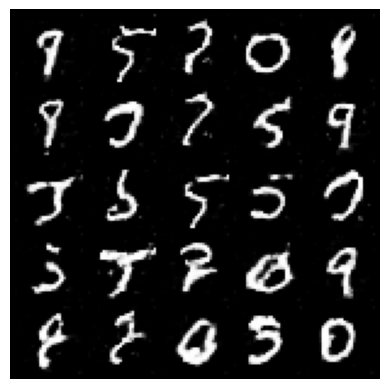

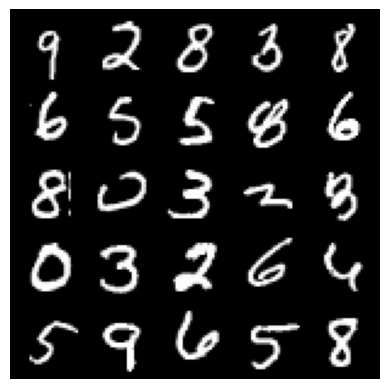

100%|██████████| 469/469 [00:10<00:00, 43.32it/s]


In [16]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_real_pred = disc(real)
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred)

        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # Update generator 
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            display.clear_output(wait=True)
            show_tensor_images(fake, save=True, epoch=epoch, name='vanilla_dc_gan')
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [17]:
# Here you can either save or load a trained model
name = 'dcgan'
torch.save(gen.state_dict(), name)
#gen.load_state_dict(torch.load(name))

<h2> Wasserstein GAN with Gradient Penalty (WGAN-GP) </h2>

A continuación, deberá implementar una WGAN-GP que resuelve alguno de los problemas de estabilidad en el entrenamiento de GANs. <br>En este modelo, se modifica la loss estándar por la W-loss correspondiente a una distancia de Wasserstein, y se agrega un término de penalización por gradiente que ayuda a prevenir el problema del <i>mode collapse</i>.

Debido a que los cambios del modelo son hechos a la loss, es posible utilizar el mismo Generador y Discriminador de la DCGAN. <br>En esta ocasión, el discriminador pasará a llamarse crítico, por su función de entregar valores reales a cada uno de los ejemplos presentados, en vez de clasificarlos como real/falso.

Comenzaremos por definir una función de utilidad para poder hacer seguimiento de los valores del gradiente, e inicializar nuevamente los pesos.

In [16]:
def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [17]:
# New training parameters
n_epochs = 100
display_step = 50
c_lambda = 10
crit_repeats = 5

In [18]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Discriminator().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty

La loss del discriminador requerirá de un término adicional de penalización.
Este corresponde a 
$ \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}}[ (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 ]$ 

Para su cálculo, usted deberá:
   - Calcular $\hat{x}$, un promedio ponderado entre imágenes reales y falsas: $\hat{\mathbf{x}} = \epsilon \mathbf{x} + (1-\epsilon)G(\mathbf{z})$, siendo $\epsilon$ escogido aleatoriamente entre 0 y 1
   - Calcular el <i> score </i> entregado por el crítico a $\hat{x}$
   - Calcular el gradiente.
   - Computar el término de gradient penalty.

In [19]:
def get_gradient(crit_model, real_images, fake_images, epsilon):
    
    ### YOUR CODE HERE ###
    mixed_images = epsilon*real_images + (1-epsilon)*fake_images
    mixed_scores = crit_model(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        ### YOUR CODE HERE ###
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with how the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [20]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Well done !")

Well done !


Ahora, implemente el método `gradient_penalty` para calcular el término completo de penalización de gradiente, dado los gradientes

*    No olvide computar la esperanza 



In [21]:
def gradient_penalty(gradient):
    
    gradient = gradient.view(len(gradient), -1)

    ### YOUR CODE HERE ###
    # Calculate the magnitude of every row
    gradient_norm = torch.pow(torch.norm(gradient,dim = 1)-1,2)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean(gradient_norm)
    return penalty


In [22]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Well done !")

Well done !


## Losses

En una WGAN-GP, el discriminador se utiliza para aproximar la distancia de Wasserstein, la cual está dada por la expresión:  

$\mathbb{W} \approx \displaystyle \mathop{\mathbb{E }}_{{\mathbf{x}}}[D(\mathbf{x})] - \displaystyle \mathop{\mathbb{E }}_{\mathbf{x}'=G(\mathbf{z})} [D(G(\mathbf{z}))] + \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}} \lambda (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 $

Usted deberá implementar los métodos `get_gen_wloss` y `get_crit_wloss` que devuelvan $L_{D}$ y $L_{G}$, los cuales serán utilizados para maximizar y minimizar $\mathbb{W}$, respectivamente. 

Obs: Notar que $L_G$ sólo debería tener un término

In [23]:
def get_gen_wloss(crit_fake_pred):
    ### YOUR CODE HERE ###
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss


In [24]:
# UNIT TEST
assert torch.isclose(
    get_gen_wloss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_wloss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Well done !")

Well done !


In [25]:
def get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    ### YOUR CODE HERE ###
    loss_1 = torch.mean(crit_real_pred)
    loss_2 = c_lambda * gp
    loss_3 = get_gen_wloss(crit_fake_pred)
    crit_loss = loss_1 - loss_2 + loss_3
    return -crit_loss

In [26]:
# UNIT TEST
assert torch.isclose(
    get_crit_wloss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_wloss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Well done !")

Well done !


## Entrenamiento WGAN-GP

Usted notará que, aún corriendo en GPU, el entrenamiento será notoriamente más lento. ¿Por qué? <br>
<font size=3 color=red> <b>
la distancia de Wasserstein (también conocida como distancia de Earth Mover), es más difícil de calcular y requiere el cálculo de una expectativa a través de muestras de datos reales y generadas. Este cálculo es más costoso computacionalmente y puede requerir más pasos de entrenamiento para converger.
La penalización del gradiente para asegurar que el Discriminador cumple con la condición de Lipschitz, implica calcular el gradiente de las predicciones del Discriminador en puntos interpolados entre las muestras reales y generadas. Esto implica cálculos adicionales de gradiente y, por lo tanto, aumenta la carga computacional.
</b></font>     

Además, notar que en el entrenamiento, se realizan varias actualizaiciones del crítico por actualizaciones del generador para intentar compensar por la regularizacion aplicada, y que el generador no gane fácilmente el juego. 

Finalmente, si bien la WGAN-GP podría no ser mejor en cuanto calidad de imágenes generadas, mejora significativamente la estabilidad del entrenamiento y evita el <i> mode collapse </i>. Por esto, debería poder entrenar una WGAN-GP por muchas épocas sin sufrir de este problema.

Step 46850: Generator loss: 232.47933227539062, critic loss: -1.6108939208984379


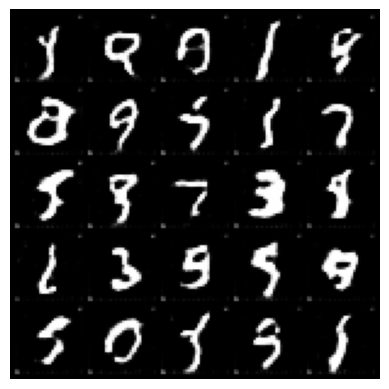

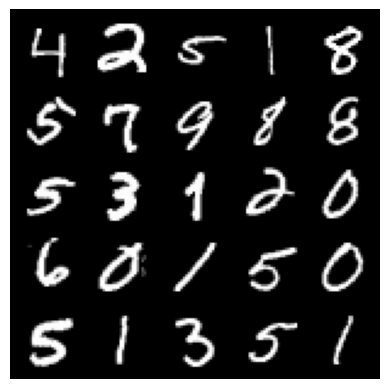

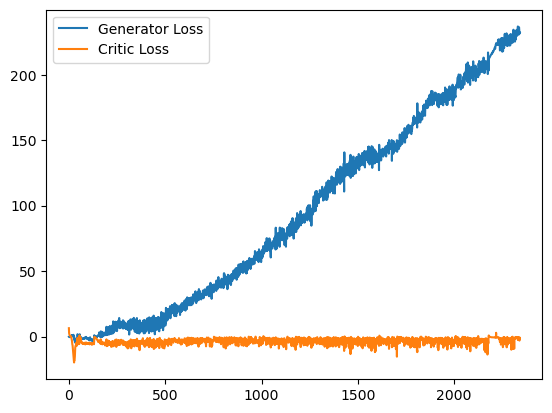

100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


In [27]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            # Update critic
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_wloss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        generator_losses += [gen_loss.item()]

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            display.clear_output(wait=True)
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake, save=True,epoch=epoch, name='wgangp')
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

In [30]:
# Here you can either save or load a trained model
name = 'wgangp'
torch.save(gen.state_dict(), name)
# gen.load_state_dict(torch.load(name)

<h2> Evaluación : Fréchet Inception Distance </h2>

In [27]:
import wget
import os
import seaborn as sns

filename = 'inception_v3_google-1a9a5a14.pth'
url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'

if not os.path.exists(filename):
    wget.download(url)

In [28]:
from torchvision.models import inception_v3

# This may take a while
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load(filename))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


**Formula**

Basado en el paper "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" la distancia de Fréchet entre dos distribuciones gaussianas multivariadas $X$ and $Y$ es:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$


Ahora usted deberá implementarla.

Obs: 

*   Le podrían ser de utilidad las funciones `torch.norm` y `torch.trace`.
*   Se le proporciona una función `matrix_sqrt()` -- usela en vez de `torch.sqrt()` que entrega la raíz cuadrada elemento por elemento. 
</details>

In [29]:
import scipy

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [30]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    ### YOUR CODE HERE ###
    fd = None
    #### START CODE HERE ####
    first = torch.norm(mu_x-mu_y)
    second = sigma_x+sigma_y - 2* matrix_sqrt(torch.matmul(sigma_x,sigma_y))
    fd = torch.pow(first,2) + torch.trace(second)
    return fd

In [31]:
# UNIT TESTS

from torch.distributions import MultivariateNormal

mean1 = torch.Tensor([0, 0])
covariance1 = torch.Tensor(
    [[1, 0],
     [0, 1]]
)
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0])
covariance2 = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(
    frechet_distance(
        dist1.mean, dist2.mean,
        dist1.covariance_matrix, dist2.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

assert (frechet_distance(
        dist1.mean, dist1.mean,
        dist1.covariance_matrix, dist1.covariance_matrix
    ).item() == 0)

print("Well done !")

Well done !


Para usar la función `frechet_distance`, se proporciona el método `get_covariance` el cual entrega la matriz de covarianza a partir de una lista de features. 

In [32]:
import numpy as np

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Finalmente, usted utilizará el modelo Inception-v3 pre-entrenado para calcular los features en imágenes reales y generadas, para luego obtener la métrica de FID de los dos modelos entrenados con anterioridad. A continuación se entrega un código para hacer el calculo de features sobre los ejemplos reales y generados.

In [33]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 5000 # The total number of samples
batch_size = 512 # Samples per iteration

dataloader = DataLoader(MNIST('.', download=False, transform=transform),
                        batch_size=batch_size,
                        shuffle=True)

def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    img = img.repeat(1,3,1,1)
    return img

def compute_features(gen):
    cur_samples = 0
    with torch.no_grad():
        try:
            for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):
                real_samples = preprocess(real_example)
                real_features = inception_model(real_samples.to(device)).detach().to('cpu')
                real_features_list.append(real_features)

                fake_samples = get_noise(len(real_example), z_dim).to(device)
                fake_samples = preprocess(gen(fake_samples))
                fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
                fake_features_list.append(fake_features)
                cur_samples += len(real_samples)
                if cur_samples >= n_samples:
                    return real_features_list, fake_features_list
                
        except:
            print("Error in loop")

In [42]:
# Load the desired generator
#gen = None
# DCGAN
gen_dcgan = Generator(z_dim).to(device)
gen_dcgan.load_state_dict(torch.load('dcgan'))
fake_features_list_dcgan=None
real_features_list_dcgan=None
fake_features_list_dcgan, real_features_list_dcgan = compute_features(gen_dcgan)

100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


Utilizando el código anterior, calcule el FID de los modelos DCGAN y WGAN-GP. Para esto: 
*     Junte los features calculados en el bloque anterior en un tensor 
*     Calcule los estadísticos necesarios
*     Utilice la función `frechet_distance` anteriormente implementada, utilizando los estadísticos previamente calculados

In [36]:
### YOUR CODE HERE ###
#DCGAN
fake_features_all = torch.reshape(torch.stack(fake_features_list_dcgan),(512,10000))
real_features_all = torch.reshape(torch.stack(real_features_list_dcgan),(512,10000))

mu_fake = torch.mean(fake_features_all,0)
mu_real = torch.mean(real_features_all,0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)
with torch.no_grad():
    print('DCGAN',frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

DCGAN 4427.5654296875


In [34]:
#wgangp
#WGAN-GP
gen_wgangp = Generator(z_dim).to(device)
gen_wgangp.load_state_dict(torch.load('wgangp'))

fake_features_list_wgangp, real_features_list_wgangp = compute_features(gen_wgangp)

fake_features_all = torch.reshape(torch.stack(fake_features_list_wgangp),(512,10000))
real_features_all = torch.reshape(torch.stack(real_features_list_wgangp),(512,10000))

mu_fake = torch.mean(fake_features_all,0)
mu_real = torch.mean(real_features_all,0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

with torch.no_grad():
    print('wgangp',frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())


100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


wgangp 4044.06103515625


A partir de las métricas calculadas, responda: 

1.    ¿Cómo se compara el desempeño de los modelos de DCGAN y WGAN-GP?  
2.    ¿Es posible evidenciar lo representado por las métricas, cualitativamente? Muestre un ejemplo.
3.    Sobre la utilización de la métrica FID, ¿Qué parte del procedimiento podría ser "no tan correcto" para el problema en cuestión?  

<font size=3 color=red> <b>

1.    WGAN_GP es más estable en el entrenamiento, por lo que se puede entrenar durante más épocas, ademas al comparar el FID se ve que la distancia de la distribucion de imagenes producidas por el segundo modelo se acerca más a las imagenes reales.
2.    Se muestra lo obtenido por lo generado en la época 49 de ambos modelos:

3.    Sobre la utilización de la métrica FID, ¿Qué parte del procedimiento podría ser "no tan correcto" para el problema en cuestión?

</b></font>     